In [322]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

In [324]:
# Function to calculate the intersection point of two lines
def line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    if denom == 0:
        return None  # Lines are parallel

    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

    return (intersect_x, intersect_y)

In [336]:
# RANSAC
def ransac_vanishing_point(intersections, threshold=10, max_iterations=1000, seed=42):
    best_inliers = []
    best_model = None
    random.seed(seed)

    for _ in range(max_iterations):
        # Randomly sample two intersection points for the line model
        sample = random.sample(intersections, 2)
        line_model = [np.array(sample[0]), np.array(sample[1])]  # Convert to NumPy

        # Calculate the distance from each intersection point to the line
        inliers = []
        for point in intersections:
            point = np.array(point)
            dist = np.linalg.norm(np.cross(line_model[1] - line_model[0], line_model[0] - point)) / np.linalg.norm(line_model[1] - line_model[0])
            if dist < threshold:
                inliers.append(point)

        # Update the best model if the number of inliers is larger
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = line_model

        # Stop early if sufficient inliers are found
        if len(best_inliers) > len(intersections) * 0.5:
            break

    # The vanishing point is the average of the inliers' coordinates
    if best_inliers:
        vanishing_point = np.mean(best_inliers, axis=0)
        return vanishing_point, best_inliers
    else:
        return None, None

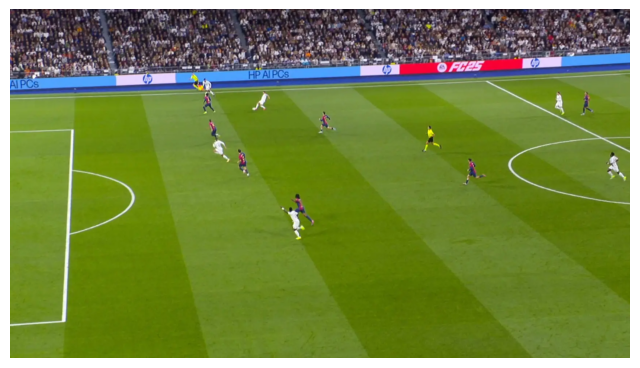

In [326]:
image = cv2.imread('madrid.png')
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

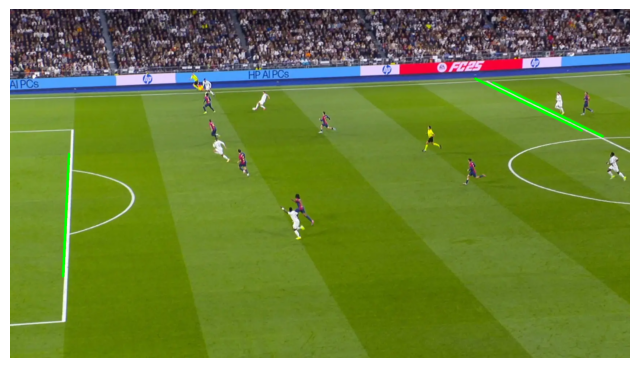

In [327]:
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
lower_white = np.array([100, 100, 100])
upper_white = np.array([255, 255, 255])
white_mask = cv2.inRange(rgb, lower_white, upper_white)
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(white_mask, kernel, iterations=1)
blurred_dilated_mask = cv2.GaussianBlur(dilated_mask, (5, 5), 0)
edges = cv2.Canny(blurred_dilated_mask, 50, 150)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=100, maxLineGap=10)

# filter lines
filtered_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    if 18 <= abs(angle) <= 89:
        filtered_lines.append(line)
for line in filtered_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 5)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [328]:
# Find intersection points between all pairs of lines
intersections = []
for i in range(len(filtered_lines)):
    for j in range(i+1, len(filtered_lines)):
        line1 = filtered_lines[i][0]
        line2 = filtered_lines[j][0]
        intersection = line_intersection(line1, line2)
        if intersection is not None:
            intersections.append(intersection)

In [339]:
# Run RANSAC to find the vanishing point
vanishing_point, inliers = ransac_vanishing_point(intersections)
print(vanishing_point)

[ 192.55257022 -245.86039884]


Vanishing Point: [ 192.55257022 -245.86039884]


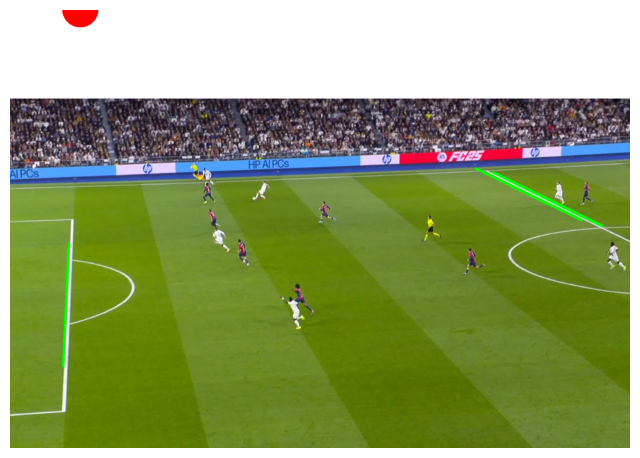

In [340]:
if vanishing_point is not None:
    print(f"Vanishing Point: {vanishing_point}")
    image_height, image_width = image.shape[:2]

    x, y = vanishing_point
    top = bottom = left = right = 0

    if x < 0:
        left = round(abs(x))
    elif x > image_width:
        right = round(x - image_width)
    if y < 0:
        top = round(abs(y))
    elif y > image_height:
        bottom = round(y - image_height)

    if top > 0 or bottom > 0 or left > 0 or right > 0:
        new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        new_vanishing_point = (round(x + left), round(y + top))
        cv2.circle(new_image, new_vanishing_point, 50, (0, 0, 255), -1)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        new_vanishing_point = (round(x), round(y))
        cv2.circle(image, vanishing_point, 5, (0, 0, 255), 5)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

else:
    print("No vanishing point found.")



# Player detection

In [341]:
from torchvision import models
import torch

In [342]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

img = cv2.imread('madrid.png')
img_tensor = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float() / 255.0

# Run inference
with torch.no_grad():
    output = model(img_tensor)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Team classification

In [343]:
def check_shirt_color(roi):
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # red
    lower_red1 = np.array([0, 120, 50])  # Lower range of red
    upper_red1 = np.array([10, 255, 150])  # Upper range of red
    lower_red2 = np.array([170, 120, 50])  # Darker range of red (second hue)
    upper_red2 = np.array([180, 255, 150])  # Darker upper range of red (second hue)

    # blue
    lower_blue = np.array([100, 100, 50])  # Darker blue range (adjusted V)
    upper_blue = np.array([130, 255, 150])  # Upper range of dark blue

    # white
    lower_white = np.array([0, 0, 180])  # Darker white range
    upper_white = np.array([180, 40, 255])  # Upper range for white color

    mask_red1 = cv2.inRange(hsv_roi, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_roi, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    mask_blue = cv2.inRange(hsv_roi, lower_blue, upper_blue)
    mask_white = cv2.inRange(hsv_roi, lower_white, upper_white)

    # Check if there's more red, blue, or white in the region
    red_pixels = cv2.countNonZero(mask_red)
    blue_pixels = cv2.countNonZero(mask_blue)
    white_pixels = cv2.countNonZero(mask_white)

    if red_pixels > blue_pixels and red_pixels > white_pixels:
        return 'Barsa'
    elif blue_pixels > red_pixels and blue_pixels > white_pixels:
        return 'Barsa'
    elif white_pixels > red_pixels and white_pixels > blue_pixels:
        return 'Madrid'
    else:
        return 'Ref'

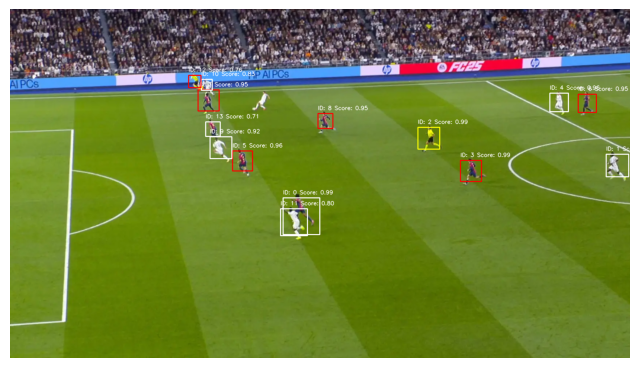

In [345]:
# keypoints and scores
keypoints = output[0]['keypoints'].cpu().numpy()
scores = output[0]['scores'].cpu().numpy()

# Set confidence threshold for visualization
confidence_threshold = 0.7

for i, score in enumerate(scores):
    if score < confidence_threshold:
        continue

    person_keypoints = keypoints[i]

    min_x = min(person_keypoints[:, 0])
    max_x = max(person_keypoints[:, 0])
    min_y = min(person_keypoints[:, 1])
    max_y = max(person_keypoints[:, 1])

    centerx = int((min_x + max_x) / 2)
    centery = int((min_y + max_y) / 2) - 10

    top_left_x = centerx - 10 // 2
    top_left_y = centery - 30 // 2
    bottom_right_x = centerx + 10 // 2
    bottom_right_y = centery + 30 // 2

    # Extract ROI
    roi = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    # Check the shirt color of the player
    shirt_color = check_shirt_color(roi)

    # Set the border color based on the shirt color
    if shirt_color == 'Barsa':
        border_color = (0, 0, 255)  # Red
    elif shirt_color == 'Ref':
        border_color = (0, 255, 255)  # Yellow
    else:
        border_color = (255, 255, 255)  # White

    box_size = max(max_x - min_x, max_y - min_y)
    top_left_x = int(min_x - (box_size - (max_x - min_x)) / 2)
    top_left_y = int(min_y - (box_size - (max_y - min_y)) / 2)
    bottom_right_x = int(top_left_x + box_size)
    bottom_right_y = int(top_left_y + box_size)

    # Draw bounding box
    cv2.rectangle(img, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), border_color, 2)
    text = f"ID: {i} Score: {score:.2f}"
    cv2.putText(img, text, (top_left_x, top_left_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# 2D to 3D using vanishing point

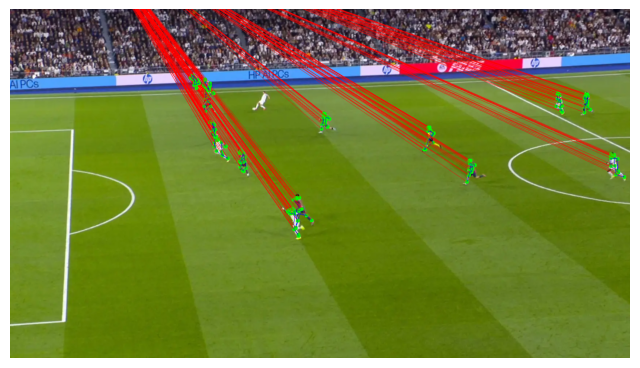

In [347]:
keypoints = output[0]['keypoints'].cpu().numpy()
scores = output[0]['scores'].cpu().numpy()

# Skeleton structure
skeleton = [
    (5, 7), (7, 9),   # Right arm
    (6, 8), (8, 10),  # Left arm
    (5, 11), (6, 12), # Torso sides
    (11, 13), (13, 15), # Right leg
    (12, 14), (14, 16)  # Left leg
]

confidence_threshold = 0.7
img = cv2.imread('madrid.png')

for i, score in enumerate(scores):
    if score < confidence_threshold:
        continue

    person_keypoints = keypoints[i]

    # Draw keypoints
    for keypoint in person_keypoints:
        x, y, _ = keypoint
        cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

        # Draw line from vanishing point to keypoint
        vanishing_point = (int(vanishing_point[0]), int(vanishing_point[1]))
        cv2.line(img, vanishing_point, (int(x), int(y)), (0, 0, 255), 1)

    # Draw skeleton
    for joint1, joint2 in skeleton:
        x1, y1, _ = person_keypoints[joint1]
        x2, y2, _ = person_keypoints[joint2]
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

